# Atak adwersarialny

## Setup i instalacja

Pobieramy przykładowy obrazek pandy oraz listę etykiet ze zbioru imagenet

In [1]:
!wget https://upload.wikimedia.org/wikipedia/commons/thumb/0/0f/Grosser_Panda.JPG/640px-Grosser_Panda.JPG
!wget https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json

--2024-07-15 17:42:14--  https://upload.wikimedia.org/wikipedia/commons/thumb/0/0f/Grosser_Panda.JPG/640px-Grosser_Panda.JPG
Resolving upload.wikimedia.org (upload.wikimedia.org)... 185.15.59.240, 2a02:ec80:300:ed1a::2:b
Connecting to upload.wikimedia.org (upload.wikimedia.org)|185.15.59.240|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 96217 (94K) [image/jpeg]
Saving to: ‘640px-Grosser_Panda.JPG’

640px-Grosser_Panda 100%[===================>]  93,96K  --.-KB/s    in 0,09s   

2024-07-15 17:42:14 (1,00 MB/s) - ‘640px-Grosser_Panda.JPG’ saved [96217/96217]

--2024-07-15 17:42:14--  https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json
Resolving s3.amazonaws.com (s3.amazonaws.com)... 54.231.161.24, 52.217.196.0, 52.217.81.22, ...
Connecting to s3.amazonaws.com (s3.amazonaws.com)|54.231.161.24|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 35363 (35K) [application/octet-stream]
Saving to: ‘imagenet_clas

In [ ]:
! git clone https://github.com/Harry24k/adversarial-attacks-pytorch
! cd adversarial-attacks-pytorch
! git checkout 23620a694a3660e4f194c3e4d28992bced7785a1

Instalujemy zależności - tutaj torch i torchvision zostawiam do własnoręcznej instalacji, a informacje o użytej wersji pozostawiam poniżej.

In [ ]:
! pip install pillow, matplotlib, 'transformers[torch]'

In [ ]:
# torch==2.2.0+cu118, 
# torchvision==0.17.0+cu118, 
# torchattacks 23620a694a3660e4f194c3e4d28992bced7785a1
# PIL==10.2.0, 
# matplotlib==10.2.0
# transformers==4.37.2

In [2]:
import sys
sys.path.insert(0, 'adversarial-attacks-pytorch')

import torch
import torch.nn as nn
import torchattacks

## Load model and data

In [3]:
from PIL import Image
from transformers import ConvNextImageProcessor, ConvNextForImageClassification
import torch
import torchvision.transforms as T

In [4]:
import json
class_idx = json.load(open("imagenet_class_index.json"))

In [5]:
HFmodel = ConvNextForImageClassification.from_pretrained("facebook/convnext-ground_truth_id-384-22k-1k", cache_dir="./cache").eval()
model = next(HFmodel.modules())

In [6]:

class MyModel(torch.nn.Module):

    def __init__(self):
        super(MyModel, self).__init__()
        self.model = model
        self.training = False

    def forward(self, x):
        x = self.model(x)
        return x.logits

In [7]:
nm = MyModel()

In [12]:
image_path = '640px-Grosser_Panda.JPG'
image = Image.open(image_path)
torch_original = T.ToTensor()(image)
torch_original = T.Resize([480, 640])(torch_original)

## Adversarial Attack (Targeted)

In [78]:
res = nm(torch_original.unsqueeze(0))
base_prediction = torch.argmax(res).item()
class_name = class_idx[str(base_prediction)]
print(f"The base image prediction id is: {base_prediction}, class: {class_name}")

The base image prediction id is: 388, class: ['n02510455', 'giant_panda']


In [79]:
target_id = 368
ground_truth_id = 388
target_class_name = class_idx[str(target_id)]

In [76]:
print(f"The target prediction id is: {target_id}, class: {target_class_name}")

The target prediction id is: 368, class: ['n02483362', 'gibbon']


In [42]:
tf = lambda x: torch.tensor([target_id])
target_fun = lambda images, labels:tf(labels)

target = tf(ground_truth_id)
atk = torchattacks.PGD(nm, eps=1/255, alpha=1/255, steps=4)
atk.set_normalization_used(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
atk.set_mode_targeted_by_function(target_map_function=target_fun)

adv_images = atk(torch_original.unsqueeze(0), torch.tensor([ground_truth_id]))

logits = nm(adv_images)
prediction = torch.argmax(logits).item()
message = "CORRECT!" if target==prediction else "Wrong!"
print(f"{message} target:{target}, prediction:{prediction}, ground_truth_id was:{ground_truth_id}")

Attack mode is changed to 'targeted(custom)'.
CORRECT! target:tensor([368]), prediction:368, ground_truth_id was:388


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, "Class: ['n02510455', 'giant_panda']")

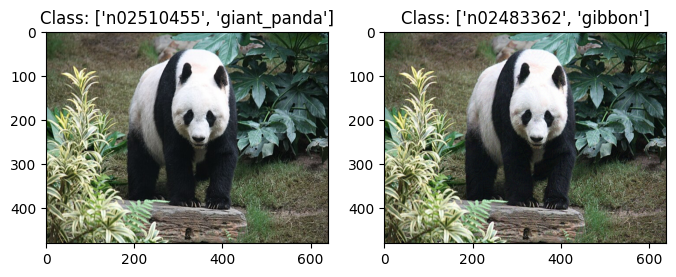

In [80]:
fig, axe = plt.subplots(1,2, figsize = (8,6))

crafted_image = adv_images[0].detach().permute(1,2,0).cpu().numpy()
original_image = torch_original.detach().permute(1,2,0).cpu().numpy()
axe[1].imshow(crafted_image)
crafted_class_name = class_idx[str(prediction)]
axe[1].set_title(f"Class: {crafted_class_name}")
axe[0].imshow(original_image)
axe[0].set_title(f"Class: {class_name}")